In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

OUTPUT_EXP26_DIR = DIR + '/output/EXP026/'
OUTPUT_EXP53_DIR = DIR + '/output/EXP053/'
OUTPUT_EXP54_DIR = DIR + '/output/EXP054/'
OUTPUT_EXP70_DIR = DIR + '/output/EXP070/'
OUTPUT_EXP71_DIR = DIR + '/output/EXP071/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

In [4]:
!pip install feature_engine

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing
from feature_engine.encoding import WoEEncoder

In [5]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(471283, 12)


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction


(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [6]:
v3_pred_df = pd.read_pickle(OUTPUT_EXP26_DIR+'oof_df.pkl')
v3_pred_df.rename(columns={"pred":"v3_pred"},inplace=True)
#v3_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_microsoft-deberta-v3-base_seed42_ver26.csv"), header=None)
#v3_test.columns = ["index", "pred", "is_fraud?",	"pred_v3_fold0",	"pred_v3_fold1",	"pred_v3_fold2",	"pred_v3_fold3",	"pred_v3_fold4"]

v1_pred_df = pd.read_pickle(OUTPUT_EXP53_DIR+'oof_df.pkl')
v1_pred_df.rename(columns={"pred":"v1_pred"},inplace=True)
#v1_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_microsoft-deberta-base_seed42_ver53.csv"), header=None)
#v1_test.columns = ["index", "pred", "is_fraud?",	"pred_v1_fold0",	"pred_v1_fold1",	"pred_v1_fold2",	"pred_v1_fold3",	"pred_v1_fold4"]

roberta_pred_df = pd.read_pickle(OUTPUT_EXP54_DIR+'oof_df.pkl')
roberta_pred_df.rename(columns={"pred":"roberta_pred"},inplace=True)
#roberta_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_roberta-base_seed42_ver54.csv"), header=None)
#roberta_test.columns = ["index", "pred", "is_fraud?",	"pred_roberta_fold0",	"pred_roberta_fold1",	"pred_roberta_fold2",	"pred_roberta_fold3",	"pred_roberta_fold4"]

funnel_pred_df = pd.read_pickle(OUTPUT_EXP70_DIR+'oof_df.pkl')
funnel_pred_df.rename(columns={"pred":"funnel_pred"},inplace=True)
#funnel_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_funnel-transformer-medium_seed42_ver70.csv"), header=None)
#funnel_test.columns = ["index", "pred", "is_fraud?",	"pred_funnel_fold0",	"pred_funnel_fold1",	"pred_funnel_fold2",	"pred_funnel_fold3",	"pred_funnel_fold4"]

electra_pred_df = pd.read_pickle(OUTPUT_EXP71_DIR+'oof_df.pkl')
electra_pred_df.rename(columns={"pred":"electra_pred"},inplace=True)
#electra_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_google-electra-base-discriminator_seed42_ver71.csv"), header=None)
#electra_test.columns = ["index", "pred", "is_fraud?",	"pred_electra_fold0",	"pred_electra_fold1",	"pred_electra_fold2",	"pred_electra_fold3",	"pred_electra_fold4"]

In [7]:
oof56_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_logistic_ver56.csv'))
oof56_df.rename(columns={"pred":"oof56_logistic_pred"},inplace=True)
#oof56_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_logistic_ver56.csv"))

oof65_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_ridge_ver65.csv'))
oof65_df.rename(columns={"pred":"oof65_ridge_pred"},inplace=True)
#oof65_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_ridge_ver65.csv"))

oof57_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_knn_ver57.csv'))
oof57_df.rename(columns={"pred":"oof57_knn3_pred"},inplace=True)
#oof57_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_knn_ver57.csv"))

oof58_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_knn_ver58.csv'))
oof58_df.rename(columns={"pred":"oof58_knn5_pred"},inplace=True)
#oof58_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_knn_ver58.csv"))

oof59_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_knn_ver59.csv'))
oof59_df.rename(columns={"pred":"oof59_knn8_pred"},inplace=True)
#oof59_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_knn_ver59.csv"))

oof60_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_knn_ver60.csv'))
oof60_df.rename(columns={"pred":"oof60_knn12_pred"},inplace=True)
#oof60_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_knn_ver60.csv"))

oof69_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_rf_ver69.csv'))
oof69_df.rename(columns={"pred":"oof69_rf_pred"},inplace=True)
#oof69_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_rf_ver69.csv"))

oof74_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_et_ver74.csv'))
oof74_df.rename(columns={"pred":"oof74_et_pred"},inplace=True)
#oof74_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_et_ver74.csv"))

In [8]:
v3_pred_df["oof56_logistic_pred"] = oof56_df["oof56_logistic_pred"]
v3_pred_df["oof65_ridge_pred"] = oof65_df["oof65_ridge_pred"]
v3_pred_df["oof57_knn3_pred"] = oof57_df["oof57_knn3_pred"]
v3_pred_df["oof58_knn5_pred"] = oof58_df["oof58_knn5_pred"]
v3_pred_df["oof59_knn8_pred"] = oof59_df["oof59_knn8_pred"]
v3_pred_df["oof60_knn12_pred"] = oof60_df["oof60_knn12_pred"]
v3_pred_df["oof69_rf_pred"] = oof69_df["oof69_rf_pred"]
v3_pred_df["oof74_et_pred"] = oof74_df["oof74_et_pred"]

In [9]:
v3_pred_df

,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,...,kfold,v3_pred,oof56_logistic_pred,oof65_ridge_pred,oof57_knn3_pred,oof58_knn5_pred,oof59_knn8_pred,oof60_knn12_pred,oof69_rf_pred,oof74_et_pred
0,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,...,0,0.002395,0.022164,0,0.0,0.0,0.000,0.000000,0.020071,0.026112
1,8,986,0,$19.9,OK,0,405337,Rio de Janeiro,Brazil,unknown,...,0,0.245824,0.011287,0,0.0,0.0,0.000,0.000000,0.094184,0.093709
2,9,541,3,$159.374,OK,0,194570,Orlando,FL,32839.0,...,0,0.041124,0.093182,1,0.0,0.0,0.000,0.083333,0.067898,0.048652
3,17,236,1,$3.118,OK,0,163836,Lincoln,NE,68521.0,...,0,0.004424,0.089049,1,0.0,0.0,0.000,0.000000,0.033826,0.055310
4,20,1149,1,$8.0,OK,0,179614,Las Vegas,NV,89109.0,...,0,0.345407,0.128041,1,0.0,0.0,0.125,0.083333,0.084711,0.058180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471278,471268,1115,0,$16.381,OK,0,333546,ONLINE,unknown,unknown,...,4,0.040566,0.083121,1,0.0,0.0,0.000,0.166667,0.174093,0.182220
471279,471269,1529,2,$108.552,OK,0,258383,Vance,AL,35490.0,...,4,0.025397,0.041508,0,0.0,0.0,0.000,0.000000,0.057163,0.068575
471280,471271,1001,1,$10.411,OK,0,176121,Sterling,IL,61081.0,...,4,0.013608,0.019483,0,0.0,0.0,0.000,0.000000,0.031568,0.045927
471281,471278,1572,0,$51.245,OK,0,325177,Lake Orion,MI,48362.0,...,4,0.005639,0.017251,0,0.0,0.0,0.000,0.000000,0.026138,0.048366


In [10]:
train = train.merge(v3_pred_df[["index", "v3_pred","oof56_logistic_pred", "oof65_ridge_pred", "oof57_knn3_pred", "oof58_knn5_pred", "oof59_knn8_pred", "oof60_knn12_pred", "oof69_rf_pred", "oof74_et_pred", "kfold"]], how="left", on="index")\
.merge(v1_pred_df[["index", "v1_pred", "kfold"]], how="left", on=["index","kfold"]).merge(roberta_pred_df[["index", "roberta_pred", "kfold"]], how="left", on=["index","kfold"]).merge(funnel_pred_df[["index", "funnel_pred", "kfold"]], how="left", on=["index","kfold"])\
.merge(electra_pred_df[["index", "electra_pred", "kfold"]], how="left", on=["index","kfold"])

In [11]:
train.head(3)

,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,...,oof58_knn5_pred,oof59_knn8_pred,oof60_knn12_pred,oof69_rf_pred,oof74_et_pred,kfold,v1_pred,roberta_pred,funnel_pred,electra_pred
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,...,0.0,0.0,0.0,0.027680,0.034623,3,0.007156,0.009872,0.006189,0.012007
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,...,0.0,0.0,0.0,0.020071,0.026112,0,0.002065,0.001569,0.002745,0.002182
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,...,0.0,0.0,0.0,0.028444,0.033529,2,0.029314,0.060902,0.035393,0.038071


In [12]:
month_dict = {
   "01": 1,
   "02": 2,
   "03": 3,
   "04": 4,
   "05": 5,
   "06": 6,
   "07": 7,
   "08": 8,
   "09": 9,
   "10": 10,
   "11": 11,
   "12": 12
}

def get_expires_values(df):
  _df = df["expires"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["expires_month"] = _df["month"].astype(str)
  df["expires_years"] = _df["years"].astype(int)
  return df

def get_acct_open_date_values(df):
  _df = df["acct_open_date"].str.split('/').apply(pd.Series)
  _df.columns = ["month","years"]
  df["acct_open_date_month"] = _df["month"].astype(str)
  df["acct_open_date_years"] = _df["years"].astype(int)
  return df


card = get_expires_values(card)
card = get_acct_open_date_values(card)
card["expires_month"] = card["expires_month"].map(month_dict)
card["acct_open_date_month"] = card["acct_open_date_month"].map(month_dict)

card["dt_acct_open_date"] = pd.to_datetime(card["acct_open_date"])
card["dt_expires"] = pd.to_datetime(card["expires"])

tmps = []
card["index"] = 1
for id in list(card.user_id.unique()):
  tmp = card.loc[card["user_id"]==id].sort_values("dt_acct_open_date")
  tmp["have_card"] = tmp["index"].cumsum()  # x枚目のカード
  tmps.append(tmp[["user_id", "card_id", "have_card"]])
card_h = pd.concat(tmps)
card = card.merge(card_h, how="left", on=["user_id", "card_id"])

In [13]:
card["credit_limit"] = card["credit_limit"].astype(str).str.extract("(\d+)").astype("float32")
user["per_capita_income_zipcode"] = user["per_capita_income_zipcode"].astype(str).str.extract("(\d+)").astype("float32")
user["yearly_income_person"] = user["yearly_income_person"].astype(str).str.extract("(\d+)").astype("float32")
user["total_debt"] = user["total_debt"].astype(str).str.extract("(\d+)").astype("float32")

In [14]:
use_limit = card.groupby("user_id")["credit_limit"].sum().to_dict()
card["credit_limit_sum"] = card["user_id"].map(use_limit)

In [15]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [16]:
concat_data = pd.concat([train,test],axis=0)
concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

concat_data = concat_data.fillna("NAN")

In [17]:
# 買った町と住んでいる町が一致していれば1
concat_data["merchant_address_city"] = 0
concat_data.loc[concat_data["merchant_city"]==concat_data["city"], "merchant_address_city"] = 1

# オンライン１　現地0
concat_data["is_ONLINE"] = 0
concat_data.loc[concat_data["merchant_city"]=="ONLINE", "is_ONLINE"] = 1

# 家の住所と購買距離
lat_state_mean = concat_data.groupby("state")["latitude"].mean().to_dict()
lon_state_mean = concat_data.groupby("state")["longitude"].mean().to_dict()
lat_mean = concat_data["latitude"].mean()
lon_mean = concat_data["longitude"].mean()
concat_data["merchant_lat"] = concat_data["merchant_state"].map(lat_state_mean)
concat_data["merchant_lon"] = concat_data["merchant_state"].map(lon_state_mean)
concat_data["merchant_lat"] = concat_data["merchant_lat"].fillna(lat_mean)
concat_data["merchant_lon"] = concat_data["merchant_lon"].fillna(lon_mean)
concat_data["merchant_address_distance"] = np.sqrt((concat_data["latitude"]-concat_data["merchant_lat"])**2 + (concat_data["longitude"]-concat_data["merchant_lon"])**2)

In [18]:
city_c = concat_data["merchant_city"].value_counts(normalize=True).to_dict()
state_c = concat_data["merchant_state"].value_counts(normalize=True).to_dict()

concat_data["city_c"] = concat_data["merchant_city"].map(lambda x: city_c[x]).values
concat_data["state_c"] = concat_data["merchant_state"].map(lambda x: state_c[x]).values

concat_data.loc[concat_data["city_c"]<0.0005, "merchant_city"] = "Rare_city"
concat_data.loc[concat_data["state_c"]<0.0005, "merchant_state"] = "Rare_state"

In [19]:
for col in ["errors?", "merchant_city", "merchant_state", "use_chip", "card_brand", "card_type", "has_chip", "gender", "city", "state"]:
  print(col)
  le = preprocessing.LabelEncoder()
  le.fit(concat_data[col])
  concat_data[col] = le.transform(concat_data[col])

errors?
merchant_city
merchant_state
use_chip
card_brand
card_type
has_chip
gender
city
state


In [20]:
income_mean = concat_data["yearly_income_person"].mean()
concat_data["income_all_rate"] = concat_data["yearly_income_person"] / income_mean  # 平均年収の稼いでいる割合
concat_data["income_rate"] = concat_data["yearly_income_person"] / concat_data["per_capita_income_zipcode"]  # 市町村の平均年収の何倍その人が稼いでいるか
concat_data["debt_rate"] = concat_data["total_debt"] / concat_data["yearly_income_person"]  # ローン総額の年収に対する割合
concat_data["limit_rate"] = concat_data["credit_limit_sum"] / concat_data["yearly_income_person"]  # 利用上限総額に対する年収の割合
concat_data["amount_rate"] = concat_data["amount"] / concat_data["credit_limit"]   # 買い物した額の上限額の割合
concat_data["diff_retire_age"] = concat_data["retirement_age"] - concat_data["current_age"]  # 退職してからの年数
concat_data["period_use_card"] = (concat_data["expires_years"] - concat_data["acct_open_date_years"])*12 + (concat_data["expires_month"] - concat_data["acct_open_date_month"])  # カード使用期間(月)
concat_data["diff_expirs_change_pin"] = concat_data["expires_years"] - concat_data["year_pin_last_changed"]  # pinコードを最後に変更した日から有効期限までの年数
concat_data["diff_change_pin_acct_open"] = concat_data["year_pin_last_changed"] - concat_data["acct_open_date_years"] # アカウント作成日からpinコードを最後に変更した日までの年数
concat_data["acct_oppen_age"] = (concat_data["acct_open_date_years"] - concat_data["birth_year"])*12 + (concat_data["acct_open_date_month"] - concat_data["birth_month"])  # アカウント作成時の年齢(月)

# コンペ開始時期でも使えるカードか否か
concat_data["current_use_card"] = 0
concat_data.loc[concat_data["expires_years"]>=2024, "current_use_card"] = 1
concat_data.loc[((concat_data["expires_years"]>=2023) & (concat_data["expires_month"]>=8)), "current_use_card"] = 1


In [21]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [22]:
numerical_features = ["amount", "cards_issued", "credit_limit", "current_age", "retirement_age", "birth_year", "latitude", "longitude",
                      "per_capita_income_zipcode", "yearly_income_person", "total_debt", "fico_score", "num_credit_cards", "income_rate"]
ori_categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]
target = "is_fraud?"

In [23]:
amount_user_mean = concat_data.groupby("user_id")["amount"].mean().to_dict()
train_df["amount_mean"] = train_df["user_id"].map(lambda x: amount_user_mean[x]).values
test_df["amount_mean"] = test_df["user_id"].map(lambda x: amount_user_mean[x]).values
train_df["diff_amount"] = train_df["amount"] - train_df["amount_mean"]
test_df["diff_amount"] = test_df["amount"] - test_df["amount_mean"]

In [24]:
train_df["neg_is_franud?"] = pd.Series(np.where(train_df[target]==1.0, 0.0, 1.0))
total_pos = train_df[target].sum()
total_neg = train_df["neg_is_franud?"].sum()

for col in ori_categorical_features:
  print(col)
  if col=="merchant_id":
    continue
  pos = train_df.groupby(col)[target].sum() / total_pos
  neg = train_df.groupby(col)["neg_is_franud?"].sum() / total_neg
  woe = pos/neg
  train_df[f"{col}_woe"] = np.log(train_df[col].map(woe).astype(float))
  test_df[f"{col}_woe"] = np.log(test_df[col].map(woe).astype(float))

user_id
card_id
errors?
merchant_id
merchant_city


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


merchant_state
mcc
use_chip
card_brand
card_type
has_chip
gender
city
state
birth_month


In [25]:
train_df[target] = train_df[target].astype(float)
corr_list = [target] + numerical_features + [f"{col}_woe" for col in ori_categorical_features if col not in "merchant_id"]
train_df[corr_list].corr()

,is_fraud?,amount,cards_issued,credit_limit,current_age,retirement_age,birth_year,latitude,longitude,per_capita_income_zipcode,...,merchant_state_woe,mcc_woe,use_chip_woe,card_brand_woe,card_type_woe,has_chip_woe,gender_woe,city_woe,state_woe,birth_month_woe
is_fraud?,1.000000,0.149597,-0.007397,-0.025715,-0.012937,-0.017675,0.013430,0.011108,0.002455,-0.019102,...,0.295577,0.215924,0.225278,0.030054,0.024515,0.023347,0.017183,0.091221,0.042386,0.046113
amount,0.149597,1.000000,-0.037866,0.084524,0.023139,-0.030107,-0.023042,-0.002821,-0.041324,0.154798,...,0.096415,0.114324,0.083184,0.010130,0.001320,0.012968,-0.019735,-0.022535,-0.056414,-0.050840
cards_issued,-0.007397,-0.037866,1.000000,-0.064020,-0.044524,-0.018097,0.043976,0.060634,-0.023949,-0.005225,...,-0.021674,-0.011799,-0.017527,-0.072797,0.013158,0.015306,-0.075932,0.013628,-0.021174,0.029326
credit_limit,-0.025715,0.084524,-0.064020,1.000000,-0.080352,0.006515,0.080956,0.092856,-0.073889,0.440021,...,0.025703,0.006251,0.006417,-0.141868,-0.459051,-0.034776,0.015439,-0.032624,0.044000,-0.055505
current_age,-0.012937,0.023139,-0.044524,-0.080352,1.000000,0.019487,-0.999726,-0.124155,0.031799,-0.008372,...,0.022004,0.009978,-0.000593,-0.099158,0.057243,-0.020377,-0.044322,-0.149934,-0.120522,0.034517
retirement_age,-0.017675,-0.030107,-0.018097,0.006515,0.019487,1.000000,-0.021244,0.061564,0.079153,-0.119159,...,-0.037914,-0.006190,0.008893,-0.023159,-0.025785,-0.031450,-0.019119,-0.177096,-0.034974,0.007626
birth_year,0.013430,-0.023042,0.043976,0.080956,-0.999726,-0.021244,1.000000,0.124970,-0.029487,0.005640,...,-0.020390,-0.010031,0.001345,0.100585,-0.058511,0.019226,0.044416,0.152521,0.124589,-0.025175
latitude,0.011108,-0.002821,0.060634,0.092856,-0.124155,0.061564,0.124970,1.000000,0.038502,0.078695,...,0.073812,-0.013868,-0.008528,-0.021290,-0.076998,-0.052635,0.127250,0.133762,0.269481,0.069878
longitude,0.002455,-0.041324,-0.023949,-0.073889,0.031799,0.079153,-0.029487,0.038502,1.000000,-0.228946,...,-0.004897,-0.030780,-0.003158,0.057189,-0.054855,0.053170,-0.024717,0.024449,0.048816,0.006158
per_capita_income_zipcode,-0.019102,0.154798,-0.005225,0.440021,-0.008372,-0.119159,0.005640,0.078695,-0.228946,1.000000,...,0.028039,0.027478,0.014517,-0.073518,-0.061816,-0.039089,-0.026715,-0.140201,-0.074656,-0.188863


In [26]:
def get_score(labels, outputs):
    y_pred = outputs
    y_true = labels
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.2, 0.80, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        #print("Accuracy score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred>best_thresh).astype(int))

In [27]:
def get_feature_importances(data, shuffle, train_features, seed=None):

    # Go over fold and keep track of CV score (train and valid) and feature importances

    # Shuffle target if required
    data['is_fraud?'] = data['is_fraud?'].astype(int)
    y = data['is_fraud?'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['is_fraud?'].copy().sample(frac=1.0)

    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }

    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_features)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    y_pred = clf.predict(data[train_features])
    imp_df['trn_score'] = f1_score(y, (y_pred>0.5).astype(int))

    return imp_df

In [28]:
features = numerical_features + ori_categorical_features + [f"{col}_woe" for col in ori_categorical_features if col not in "merchant_id"]  + ["amount_mean", "diff_amount"] \
+ ["debt_rate", "limit_rate", "amount_rate", "diff_retire_age", "period_use_card", "diff_expirs_change_pin", "diff_change_pin_acct_open", "acct_oppen_age",
 "merchant_address_distance", "credit_limit_sum", "have_card", "acct_open_date_years", "expires_years"] + \
  ["current_use_card", "merchant_address_city","expires_month", "acct_open_date_month", "is_ONLINE", "income_all_rate", "city_c", "state_c"] + \
  ["oof56_logistic_pred", "oof65_ridge_pred", "oof57_knn3_pred", "oof58_knn5_pred", "oof59_knn8_pred", "oof60_knn12_pred", "oof69_rf_pred", "oof74_et_pred"] + \
  ["v3_pred", "v1_pred", "roberta_pred", "funnel_pred", "electra_pred"]
categorical_features = ori_categorical_features +  ["current_use_card", "merchant_address_city","expires_month", "acct_open_date_month"]
oof_features = ["oof56_logistic_pred", "oof65_ridge_pred", "oof57_knn3_pred", "oof58_knn5_pred", "oof59_knn8_pred", "oof60_knn12_pred", "oof69_rf_pred", "oof74_et_pred"] + ["v3_pred", "v1_pred", "roberta_pred", "funnel_pred", "electra_pred"]

for col in oof_features:
  train_df[col] = train_df[col].astype(float)

In [29]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=train_df, shuffle=False, train_features=features)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 32631, number of negative: 438652
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14208
[LightGBM] [Info] Number of data points in the train set: 471283, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069239 -> initscore=-2.598444
[LightGBM] [Info] Start training from score -2.598444


In [30]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,amount,15900.208506,341,0.637418
1,cards_issued,579.232502,15,0.637418
2,credit_limit,12097.340391,249,0.637418
3,current_age,2076.092106,49,0.637418
4,retirement_age,5172.006191,113,0.637418


In [31]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train_df, shuffle=True, train_features=features)
    imp_df['run'] = i + 1
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [32]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,amount,9875.753084,1182,0.0,1
1,cards_issued,521.049544,53,0.0,1
2,credit_limit,3214.420557,369,0.0,1
3,current_age,709.995006,79,0.0,1
4,retirement_age,1499.081037,125,0.0,1


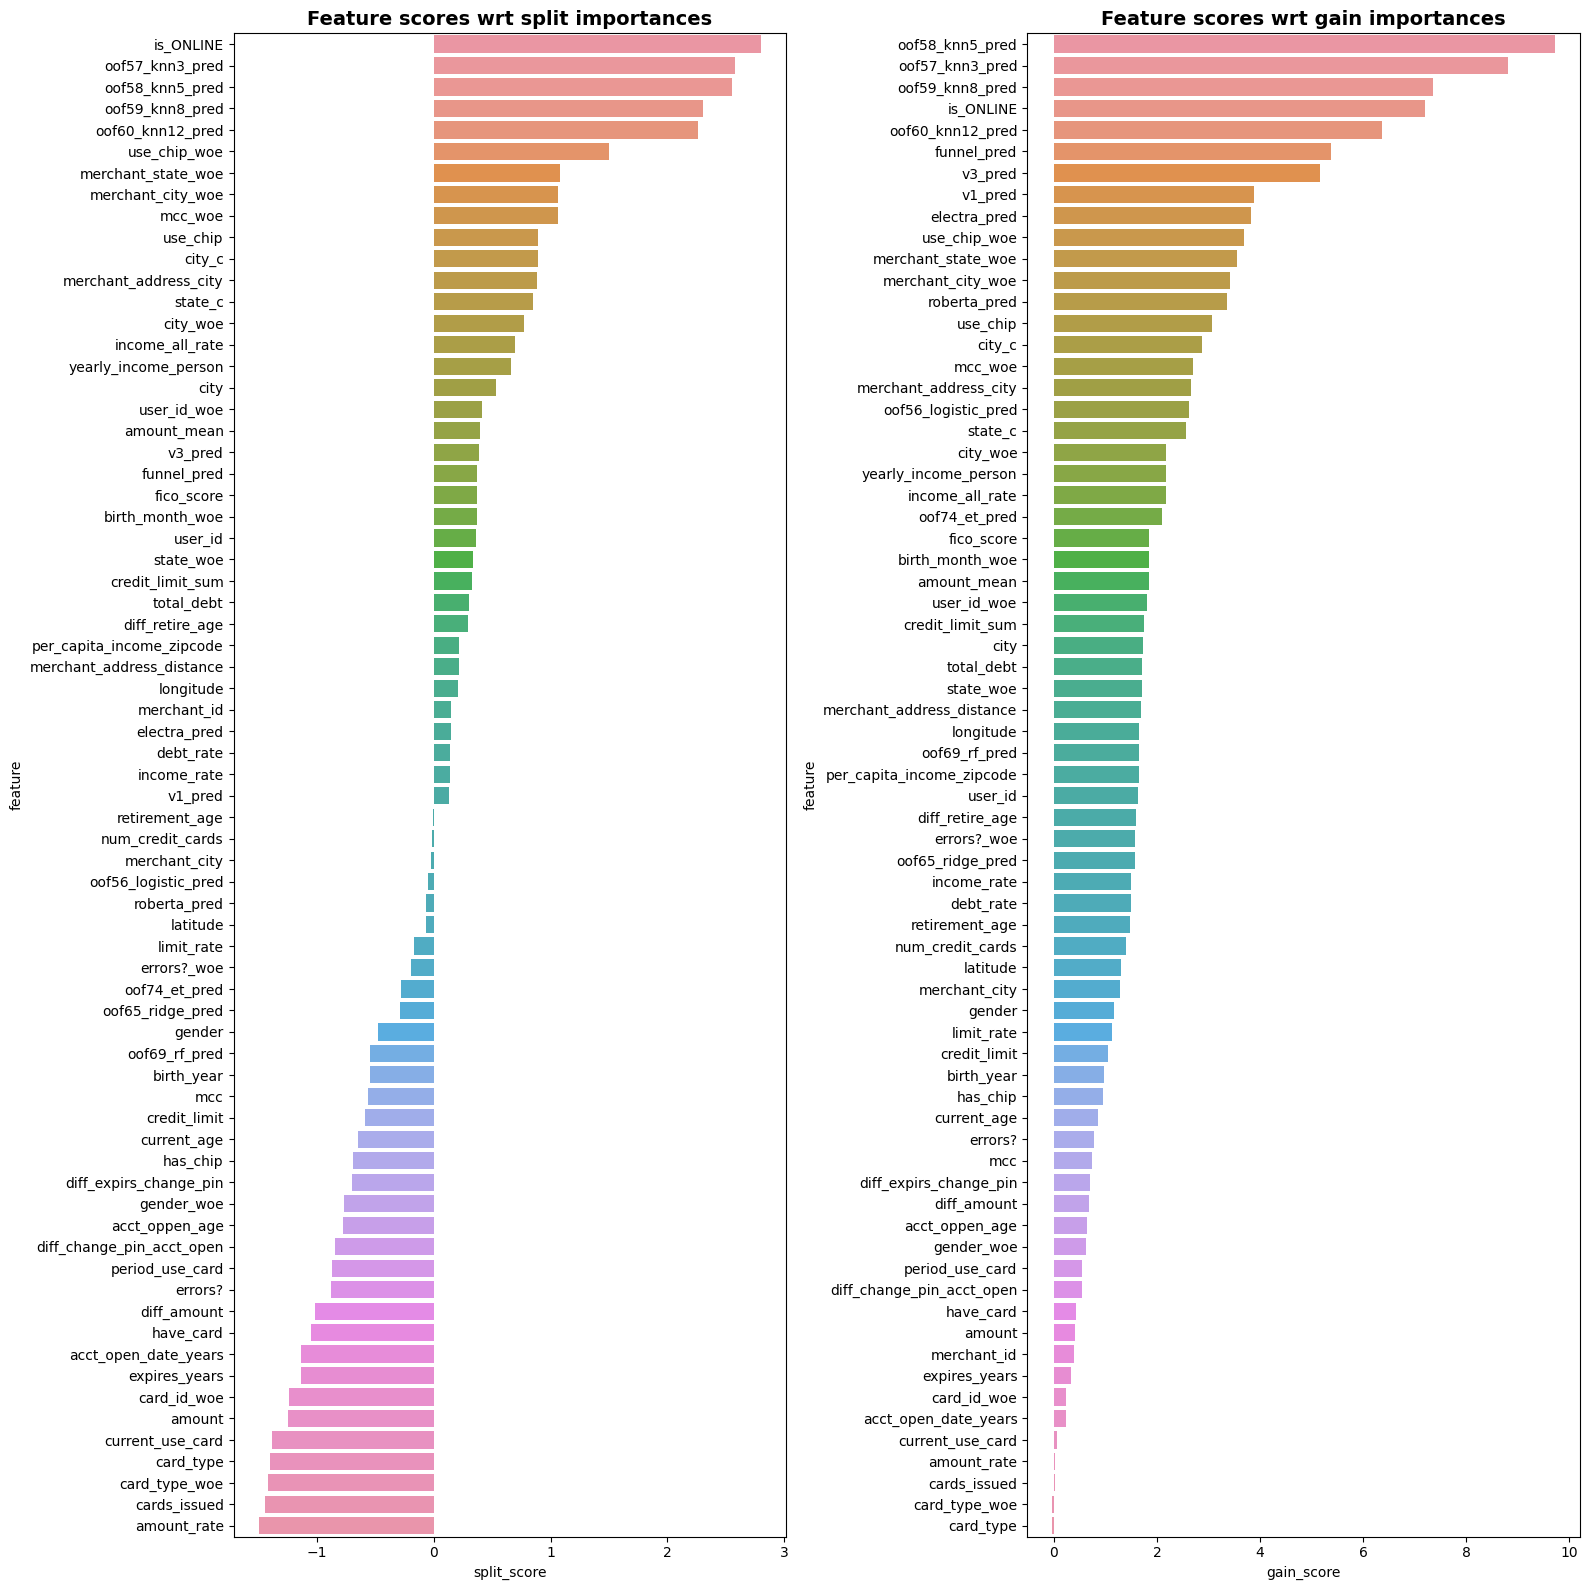

In [33]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

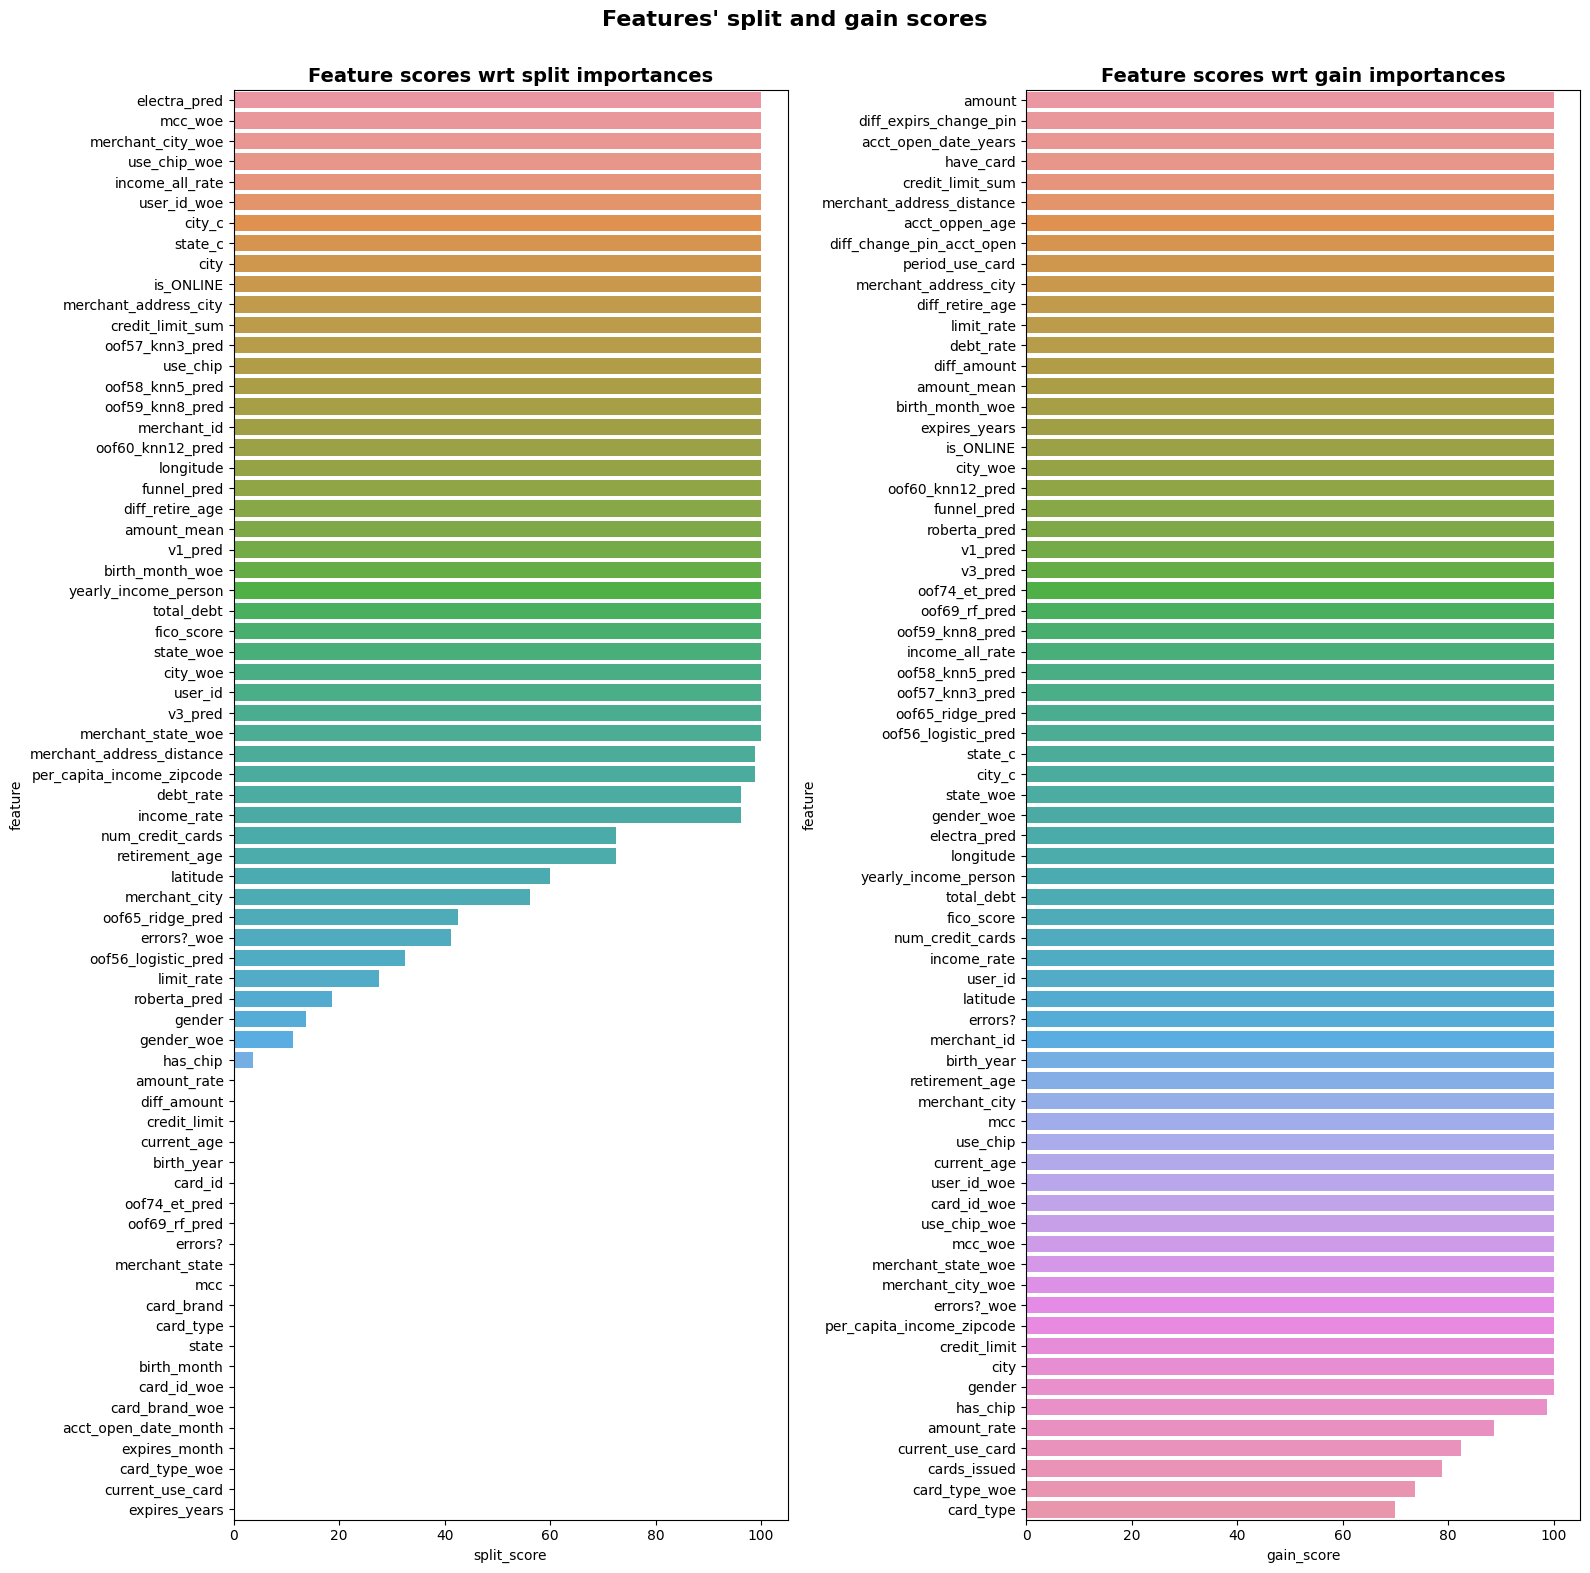

In [34]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [35]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc',
        #'silent':True
    }

    # Fit the model
    hist = lgb.cv(
        params=lgb_params,
        train_set=dtrain,
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        #early_stopping_rounds=50,
        #verbose_eval=0,
        seed=17,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0),
        ],
    )
    # Return the last mean / std values
    return hist['valid auc-mean'][-1], hist['valid auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_features)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_features)]

    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=train_df, train_features=split_feats, cat_feats=split_cat_feats, target=train_df['is_fraud?'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=train_df, train_features=gain_feats, cat_feats=gain_cat_feats, target=train_df['is_fraud?'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 26105, number of negative: 350921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14197
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 79
[LightGBM] [Info] Number of positive: 26105, number of negative: 350921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14197
[LightGBM] [Info] Number of data points in the train set: 377026, number of used features: 79
[LightGBM] 

In [36]:
gain_feats20 = [_f for _f, _, _score in correlation_scores if _score >= 20]
gain_feats20

['amount',
 'cards_issued',
 'credit_limit',
 'current_age',
 'retirement_age',
 'birth_year',
 'latitude',
 'longitude',
 'per_capita_income_zipcode',
 'yearly_income_person',
 'total_debt',
 'fico_score',
 'num_credit_cards',
 'income_rate',
 'user_id',
 'errors?',
 'merchant_id',
 'merchant_city',
 'mcc',
 'use_chip',
 'card_type',
 'has_chip',
 'gender',
 'city',
 'user_id_woe',
 'card_id_woe',
 'errors?_woe',
 'merchant_city_woe',
 'merchant_state_woe',
 'mcc_woe',
 'use_chip_woe',
 'card_type_woe',
 'gender_woe',
 'city_woe',
 'state_woe',
 'birth_month_woe',
 'amount_mean',
 'diff_amount',
 'debt_rate',
 'limit_rate',
 'amount_rate',
 'diff_retire_age',
 'period_use_card',
 'diff_expirs_change_pin',
 'diff_change_pin_acct_open',
 'acct_oppen_age',
 'merchant_address_distance',
 'credit_limit_sum',
 'have_card',
 'acct_open_date_years',
 'expires_years',
 'current_use_card',
 'merchant_address_city',
 'is_ONLINE',
 'income_all_rate',
 'city_c',
 'state_c',
 'oof56_logistic_pred',

In [37]:
gain_cat_feats20 = [_f for _f, _, _score in correlation_scores if (_score >= 20) & (_f in categorical_features)]
gain_cat_feats20

['user_id',
 'errors?',
 'merchant_id',
 'merchant_city',
 'mcc',
 'use_chip',
 'card_type',
 'has_chip',
 'gender',
 'city',
 'current_use_card',
 'merchant_address_city']

In [38]:
split_feats70 = [_f for _f, _score, _ in correlation_scores if _score >= 70]
split_cat_feats70 = [_f for _f, _score, _ in correlation_scores if (_score >= 70) & (_f in categorical_features)]

In [39]:
split_feats70

['retirement_age',
 'longitude',
 'per_capita_income_zipcode',
 'yearly_income_person',
 'total_debt',
 'fico_score',
 'num_credit_cards',
 'income_rate',
 'user_id',
 'merchant_id',
 'use_chip',
 'city',
 'user_id_woe',
 'merchant_city_woe',
 'merchant_state_woe',
 'mcc_woe',
 'use_chip_woe',
 'city_woe',
 'state_woe',
 'birth_month_woe',
 'amount_mean',
 'debt_rate',
 'diff_retire_age',
 'merchant_address_distance',
 'credit_limit_sum',
 'merchant_address_city',
 'is_ONLINE',
 'income_all_rate',
 'city_c',
 'state_c',
 'oof57_knn3_pred',
 'oof58_knn5_pred',
 'oof59_knn8_pred',
 'oof60_knn12_pred',
 'v3_pred',
 'v1_pred',
 'funnel_pred',
 'electra_pred']

In [40]:
split_cat_feats70

['user_id', 'merchant_id', 'use_chip', 'city', 'merchant_address_city']